# 5. Predict

### Import pkg

In [2]:
import numpy as np
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

Using TensorFlow backend.


In [4]:
# import zipfile
import os
import zipfile
import math
import time
from IPython.display import display
import pdb
import json
from PIL import Image
import glob
import pickle

### Load model

In [5]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
# from keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3

In [6]:
model = load_model('./model/Top2Inc2017-09-24_15-07-45.h5')

## Predict validation
- Load image
- Resize image
- Predict
- Get top 1 or 3 or 5
- Calculate score

### Extract zip file

In [7]:
input_path = './input'
datasetName = 'validation'
date = '20170908'

zip_path = input_path + '/ai_challenger_scene_{0}_{1}.zip'.format(datasetName, date)
extract_path = input_path + '/ai_challenger_scene_{0}_{1}'.format(datasetName, date)
image_path = extract_path + '/scene_{0}_images_{1}'.format(datasetName, date)
scene_classes_path = extract_path + '/scene_classes.csv'
scene_annotations_path = extract_path + '/scene_{0}_annotations_{1}.json'.format(datasetName, date)

print(input_path)
print(zip_path)
print(extract_path)
print(image_path)
print(scene_classes_path)
print(scene_annotations_path)

./input
./input/ai_challenger_scene_validation_20170908.zip
./input/ai_challenger_scene_validation_20170908
./input/ai_challenger_scene_validation_20170908/scene_validation_images_20170908
./input/ai_challenger_scene_validation_20170908/scene_classes.csv
./input/ai_challenger_scene_validation_20170908/scene_validation_annotations_20170908.json


In [8]:
if not os.path.isdir(extract_path):
    with zipfile.ZipFile(zip_path) as file:
        for name in file.namelist():
            file.extract(name, input_path)

### Preview "scene_classes.csv"

In [9]:
scene_classes = pd.read_csv(scene_classes_path, header=None)
display(scene_classes.head())

,0,1,2
0,0,航站楼,airport_terminal
1,1,停机坪,landing_field
2,2,机舱,airplane_cabin
3,3,游乐场,amusement_park
4,4,冰场,skating_rink


In [10]:
def get_scene_name(lable_number, scene_classes_path):
    scene_classes = pd.read_csv(scene_classes_path, header=None)
    return scene_classes.loc[lable_number, 2]
print(get_scene_name(0, scene_classes_path))

airport_terminal


### Build functions

(1, 224, 224, 3)


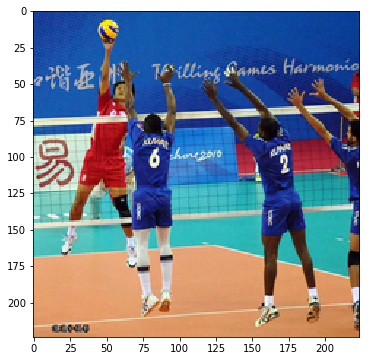

In [11]:
def process_image(image_path, fileName):
    box = (224, 224)
    img_path = image_path + '/' + fileName
    img = Image.open(img_path)
    img1 = img.resize(box, Image.ANTIALIAS) # resizes image in-place
    imgData = np.asarray(img1)
    imgData = imgData.astype("float32")
    imgData = imgData/255.0
    x = np.expand_dims(imgData, axis=0)
    return x

test_img = process_image(image_path, '0009b38c2e37181d329ea8ad3b4598f0977fdeff.jpg')
print(test_img.shape)
# print(x)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(test_img[0])

In [ ]:
def decode_predictions(pred, top=3, isPreview=False):
    top_indices = pred.argsort()[-top:][::-1]
    if not isPreview:
        return top_indices
    results  = []
    for i in top_indices:
        result = (i, pred[i])
        results.append(result)
    return results
pred = np.array([3, -1, 2, 7, -2, -1, 0, 6, -9])
print(decode_predictions(pred))
print(decode_predictions(pred, top=5))
print(decode_predictions(pred, top=8, isPreview=True))

[3 7 0]
[3 7 0 2 6]
[(3, 7), (7, 6), (0, 3), (2, 2), (6, 0), (5, -1), (1, -1), (4, -2)]


In [ ]:
preds = model.predict(test_img)
print(preds[0])
print(decode_predictions(preds[0]))
print(decode_predictions(preds[0], top=5, isPreview=True))
lable_id = decode_predictions(preds[0])[0]
print("label_id:{0} lable_text:{1}".format(lable_id, get_scene_name(lable_id, scene_classes_path)))

In [ ]:
%%time
results = []
count = 10000 # For test
if os.path.isdir(image_path):
    files = os.listdir(image_path)
    print(len(files))
    for file in files:
#         print(file)
#         print(image_path + '/' + file)
        test_img = process_image(image_path, file)
        preds = model.predict(test_img)
        labels = decode_predictions(preds[0], top=1)
        result = {}
        result['label_id'] = labels.tolist()
        result['image_id'] = file
        results.append(result)
        count = count -1
        if count <= 0:
            break

# print(results)
submit_file = './output' + '/submit' + time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime()) + '.json'
print(submit_file)
with open(submit_file, 'w') as f:
    json.dump(results, f)
    print('write result json, num is %d' % len(result))

In [ ]:
%run ./scene_classification_eval/scene_eval.py --submit ./scene_classification_eval/submit.json --ref ./scene_classification_eval/ref.json

In [ ]:
%run ./scene_classification_eval/scene_eval.py --submit ./output/submit2017-09-25_23-14-34.json  --ref ./output/scene_validation_annotations_20170908.json